In [4]:
1

1

In [5]:
import numpy as np
import tensorflow.keras
from tensorflow import keras
import torch
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, AveragePooling1D, Conv2D, MaxPooling2D,ReLU
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model #save and load models
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
import IPython.display as ipd
from kymatio import Scattering1D
import hitdifferentparts
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pescador
import random
import os
import librosa
import pickle

In [6]:
#make the model
def create_model(J,Q,order,input_x,input_y,k_size,layer_size,nchan_out):
    #fname = random.choice(os.listdir(path_to_train))
    #rand_audio = os.path.join(path_to_train,fname)
    #y,sr = librosa.load(rand_audio)
    #N = len(y)
    #scattering = Scattering1D(J = J,shape=(N,), Q = Q, max_order=order)
    
    #Sy = getsc_new(torch.Tensor(y),J,Q,order,scattering).T
    #nrow, ncol = Sy.shape 
    nrow = input_x
    ncol = input_y
    #naudio = batch_size         # number of images in batch
    nchan_in = 1       # number of input channels.  1 since it is BW
    #input_shape = (nrow,ncol,nchan_in)  # input shape of 1 image
    input_shape = (input_x,input_y)#Sy.shape
    #batch_shape = (naudio,nrow,ncol,nchan_in)  # shape of image batch
    #x = Sy.reshape(batch_shape)
    kernel_size = (k_size,)
    #nchan_out = 16

    K.clear_session()
    model=Sequential()
    #1 conv layer +  1 batch normalization + nonlinear activation + pooling
    model.add(Conv1D(input_shape=input_shape, filters=nchan_out,
                     kernel_size=kernel_size, padding="same",name='conv1'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(AveragePooling1D(pool_size=(4,)))
    
   #second time
    model.add(Conv1D(filters=nchan_out,
                     kernel_size=kernel_size, padding="same",name='conv2' ))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(AveragePooling1D(pool_size=(4,)))
    
    #third time
    if layer_size>=3:
        model.add(Conv1D(filters=nchan_out,
                         kernel_size=kernel_size, padding="same",name='conv3' ))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(AveragePooling1D(pool_size=(4,)))
        if layer_size==4:
        #fourth time
            model.add(Conv1D(filters=nchan_out,
                             kernel_size=kernel_size, padding="same",name='conv4' ))
            model.add(BatchNormalization())
            model.add(Activation("relu"))
            model.add(AveragePooling1D(pool_size=(2,)))
            if layer_size ==5:
                model.add(Conv1D(filters=nchan_out,
                             kernel_size=kernel_size, padding="same",name='conv5' ))
                model.add(BatchNormalization())
                model.add(Activation("relu"))
                model.add(AveragePooling1D(pool_size=(2,)))

    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    #what activation should be chosen for last layer, for regression problem? should be a linear function
    model.add(Dense(5, activation='linear')) #output layer that corresponds to the 5 physical parameters.


    # Compile the model
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    
    #print(model.summary())
    return model

In [7]:
features_dir = "/scratch/vl1019/han2020fa_data/han2020fa_sc-pkl/"
os.listdir(features_dir)

['scattering_J-14_Q-01_order2_fold-train.pkl',
 'scattering_J-10_Q-01_order1_fold-test.pkl',
 'scattering_J-12_Q-01_order2_fold-test.pkl',
 'scattering_J-14_Q-01_order1_fold-train.pkl',
 'scattering_J-06_Q-01_order1_fold-train.pkl',
 'scattering_J-12_Q-01_order1_fold-train.pkl',
 'scattering_J-10_Q-01_order2_fold-train.pkl',
 'scattering_J-14_Q-01_order1_fold-test.pkl',
 'scattering_J-12_Q-01_order1_fold-test.pkl',
 'scattering_J-06_Q-01_order1_fold-test.pkl',
 'scattering_J-14_Q-01_order1_fold-val.pkl',
 'scattering_J-08_Q-01_order2_fold-train.pkl',
 'scattering_J-12_Q-01_order2_fold-train.pkl',
 'scattering_J-14_Q-01_order2_fold-test.pkl',
 'scattering_J-08_Q-01_order2_fold-val.pkl',
 'scattering_J-12_Q-01_order2_fold-val.pkl',
 'scattering_J-06_Q-01_order2_fold-val.pkl',
 'scattering_J-08_Q-01_order1_fold-val.pkl',
 'scattering_J-10_Q-01_order1_fold-val.pkl',
 'scattering_J-10_Q-01_order1_fold-train.pkl',
 'scattering_J-06_Q-01_order1_fold-val.pkl',
 'scattering_J-08_Q-01_order2_fol

In [8]:
# open J-8,Q=1,O=2 pkl file
J = 8
Q = 1
order = 2
pkl_path = '/scratch/hh2263/drum_data/pkl_data/scattering_J-08_Q-01_order2.pkl'
pkl_file = open(pkl_path, 'rb')
Sy_train,y_train = pickle.load(pkl_file) 

pkl_path_val = '/scratch/hh2263/drum_data/val/J_8_Q_1_order_2.pkl'
pkl_val = open(pkl_path_val,'rb')
Sy_val,y_val = pickle.load(pkl_val)
Sy_val = Sy_val.reshape((Sy_val.shape[2],Sy_val.shape[0],Sy_val.shape[1]))

pkl_path_test = os.path.join(features_dir,"scattering_J-08_Q-01_order2_fold-test.pkl")
pkl_test = open(pkl_path_test,'rb')
Sy_test,y_test = pickle.load(pkl_test)


In [9]:
#fix everybody's physical parameters first (p and D should be log)
#print(np.log10(y_train[0,3]),y_train[0,3])
import math
for idx in range(2,4):
    y_train[:,idx] = [math.log10(i) for i in y_train[:,idx]]
    y_test[:,idx] = [math.log10(i) for i in y_test[:,idx]]
    y_val[:,idx] = [math.log10(i) for i in y_val[:,idx]]

In [10]:
input_x = Sy_train.shape[1]
input_y = Sy_train.shape[2]
print(Sy_train.shape,Sy_val.shape,y_train.shape,y_val.shape,input_x,input_y)

(82224, 128, 43) (7776, 128, 43) (82224, 5) (7776, 5) 128 43


In [11]:
df_train = pd.read_csv("./train_param.csv")
df_test = pd.read_csv("./test_param.csv")
df_val = pd.read_csv("./val_param.csv")
df_full = pd.read_csv("./diffshapes_param.csv")

# normalization of the physical parameters
params = df_train.values[:,1:-1]
#fix the p,D params to log scale
params.shape

(82224, 5)

In [12]:
for idx in range(2,4):
    params[:,idx] = [math.log10(i) for i in params[:,idx]]

In [13]:
scaler = MinMaxScaler()
scaler.fit(params)

#normalize training and validation set
y_train_normalized = scaler.transform(y_train)
y_val_normalized = scaler.transform(y_val)
y_test_normalized = scaler.transform(y_test)

In [14]:
print(y_train_normalized.shape)

(82224, 5)


In [15]:
output_dir = "../output/"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_filepath = os.path.join(output_dir, "cp_best2.h5")
log_filepath = os.path.join(output_dir, 'train_log.csv')

callbacks = []
callbacks.append(EarlyStopping(monitor='val_loss',patience=0,verbose=1))
callbacks.append(ModelCheckpoint(model_filepath, save_best_only=True))
callbacks.append(CSVLogger(log_filepath))

In [16]:
epoch = 1
trial_dir = "../output/"
epoch_str = "epoch-" + str(epoch).zfill(3)
epoch_network_path = os.path.join(
   trial_dir, "_".join(["j8o2", epoch_str]) + ".h5")
print(epoch_network_path)

../output/j8o2_epoch-001.h5


In [17]:
trial_dir = "../output/"
best_validation_loss = np.inf
n = Sy_train.shape[0]
steps_per_epoch = 10
bs = 64
m = bs*steps_per_epoch
idx = np.arange(0,n,1)
val_loss=[]
model=create_model(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)
for epoch in range(30):
    np.random.shuffle(idx)
    Sy_temp = Sy_train[idx[:m],:,:]
    y_temp = y_train_normalized[idx[:m],:]
    
    hist = model.fit(Sy_temp,
                y_temp,
                epochs=1,
                verbose=2,
                batch_size=bs,
                validation_data = (Sy_val,y_val_normalized),
                use_multiprocessing=False)
    validation_loss = hist.history['val_loss'][0]
    val_loss.append(validation_loss)
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        epoch_str = "epoch-" + str(epoch).zfill(3)
        epoch_network_path = os.path.join(
           trial_dir, "_".join(["j8o2", epoch_str]) + ".ckpt")
        model.save(epoch_network_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 640 samples, validate on 7776 samples
640/640 - 5s - loss: 0.8459 - mean_squared_error: 0.8459 - val_loss: 0.2372 - val_mean_squared_error: 0.2372
Train on 640 samples, validate on 7776 samples
640/640 - 1s - loss: 0.3624 - mean_squared_error: 0.3624 - val_loss: 0.1916 - val_mean_squared_error: 0.1916
Train on 640 samples, validate on 7776 samples
640/640 - 1s - loss: 0.2783 - mean_squared_error: 0.2783 - val_loss: 0.1560 - val_mean_squared_error: 0.1560
Train on 640 samples, validate on 7776 samples
640/640 - 1s - loss: 0.2221 - mean_squared_error: 0.2221 - val_loss: 0.1297 - val_mean_squared_error: 0.1297
Train on 640 samples, validate on 7776 samples
640/640 - 1s - loss: 0.1943 - mean_squared_error: 0.1943 - val_loss: 0.1075 - val_mean_squared_error: 0.1075
Train on 640 samples, validate on 7776 samples
640/640 - 1s - loss: 0.1470 - mean_squared_error: 0.1470 - val_loss: 0.0926 - val_mean_squar

In [24]:
class DataGenerator(tensorflow.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, Sy_train, y_train, batch_size=32, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.Sy_train = Sy_train
        self.y_train = y_train
        self.shuffle = shuffle
        #self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.Sy_train.shape[0] / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = np.arange(0,self.Sy_train.shape[0],1)
        np.random.shuffle(indexes)
        
        # Generate data
        X, y = self.__data_generation(indexes[:self.batch_size])

        return X, y

#    def on_epoch_end(self):
#        'Updates indexes after each epoch'
#        self.indexes = np.arange(len(self.list_IDs))
#        if self.shuffle == True:
#            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = self.Sy_train[list_IDs_temp,:,:]
        y = self.y_train[list_IDs_temp,:]

        return X, y
parameters = {'batch_size': 64,
          'shuffle': True}
training_generator = DataGenerator(Sy_train, y_train_normalized, **parameters)

In [ ]:
model2=create_model(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)
#model2.load_weights(model_filepath)
model2.fit(training_generator,
          steps_per_epoch=10,
          verbose=2,
          callbacks = callbacks,
          epochs = 10, 
         validation_data=(Sy_val,y_val_normalized),
          use_multiprocessing=True)

Epoch 1/10


In [18]:
model2=create_model(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)
model2.load_weights("../output/j8o2_epoch-007.ckpt")

In [19]:
#evaluate on training set
model2.evaluate(Sy_train,y_train_normalized)

82224/82224 [==============================] - 8s 99us/sample - loss: 0.1379 - mean_squared_error: 0.1379


[0.13790690756233825, 0.13790679]

In [20]:
#evaluate on test set
model2.evaluate(Sy_test,y_test_normalized)

10000/10000 [==============================] - 1s 102us/sample - loss: 0.1386 - mean_squared_error: 0.1386


[0.13861700139045716, 0.13861698]

In [21]:
#evaluate on val set
model2.evaluate(Sy_val,y_val_normalized)

7776/7776 [==============================] - 1s 101us/sample - loss: 0.0800 - mean_squared_error: 0.0800


[0.08004938519785924, 0.08004941]

## test on training set

In [22]:
example = df_train.values[0,:]
name = str(example[0])+"_sound.wav"
#p, d is original number
params = example[1:]
y,fs = librosa.load("/scratch/hh2263/drum_data/train/"+name)
print(params)

[3641.267682215784 0.14912260113032105 0.9748392162093932
 0.008955332878189611 0.6462749409737613 'train']


In [43]:
scattering = Scattering1D(J=J, shape=(2**15,), Q=Q, max_order=order)
Sx = np.array(scattering(torch.Tensor(y)).T)
predicted = model2.predict(Sx.reshape((1,128,43)))#this p,D is the log number
#print(predicted,scaler.transform(params[:5].reshape(1,-1)),np.square(predicted-scaler.transform(params[:5].reshape(1,-1))).mean())
print(predicted)#this p,D is the log number

[[0.2730493  0.7844304  0.53565776 0.3154272  0.21816818]]


In [44]:
#scaler is according to the log number 
predicted_recovered = scaler.inverse_transform(predicted)

In [45]:
predicted_recovered

array([[ 3.8879197e+03,  2.3748538e-01, -1.6961155e+00, -2.4227707e+00,
         2.1894422e-01]], dtype=float32)

In [46]:
predicted_original = predicted_recovered[0]
for i in [2,3]:
    predicted_original[i]=10**predicted_original[i]

print(predicted_original)

[3.8879197e+03 2.3748538e-01 2.0131888e-02 3.7777156e-03 2.1894422e-01]


In [48]:
import ftm 
y2 = ftm.getsounds_imp(10,10,predicted_original[0],
                       predicted_original[1],
                       predicted_original[2],
                       predicted_original[3],
                       predicted_original[4],22050)

In [49]:
ipd.Audio(y,rate=22050)

In [50]:
ipd.Audio(y2,rate=22050)

In [53]:
import soundfile as sf
sf.write('original.wav', y, 22050)
sf.write('recovered.wav',y2,22050)

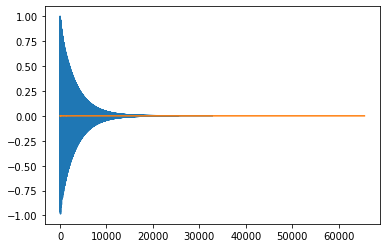

In [51]:
import matplotlib.pyplot as plt
plt.plot(y)
plt.plot(y2)

discussion
- even though the loss is 0.03 for this particular case, the recovered physical parameters are still very off. need to take into account the ratio between error and their scale. 
- each physical parameter has different tolerance of error too. does mse account for that? 